In [1]:
from BMI_HBVmountain_Python import *
from Calibration_BRC import *
import os
import netCDF4 as nc


## Load forcing and observation data

In [2]:
forcing = pd.read_csv('Data/BigCreek/forcing_bigrockcreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['Date'][i] = forcing['Date'][i].date()
forcing.set_index('Date', inplace=True)
forcing.loc[forcing['prec_era5'] > 500, 'prec_era5'] = 0

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [3]:
forcing.index = pd.to_datetime(forcing.index)
year = forcing.groupby(pd.Grouper(freq='y')).max()

In [4]:
year.temp_era5.mean()

29.623634338378906

## Setting up the model

In [5]:
model = BMI_HBVmountain()

In [6]:
config_file = model.setup()

In [7]:
model.initialize(config_file)

### Parameters

In [47]:
param_list = parameter_conversion('output')
model.set_value('bare_parameters', param_list[0][0])
model.set_value('forest_parameters', param_list[0][1])
model.set_value('grass_parameters', param_list[0][2])
model.set_value('rip_parameters', param_list[0][3])
model.set_value('slow_parameters', param_list[0][4])



### Forcings

In [48]:
model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings

In [49]:
model.set_value('Elevation', Main.Elevations(270, 1250, 2600, 1250, 1250))
model.set_value('Glacier', [0.0, 0.0, 0.0, 0.0])
model.set_value('Sunhours', [10.18, 10.90, 12.0, 13.10, 14.0, 14.45, 14.08, 13.31, 12.24, 11.25, 10.31, 9.85])
model.set_value('bare_input', Main.HRU_Input([0,0,0,0], 0, np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('forest_input', Main.HRU_Input([0.0,0.20,0.73,0.07], 0.64,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('grass_input', Main.HRU_Input([0.1,0.8,0.1,0.0], 0.35,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('rip_input', Main.HRU_Input([1.0,0,0,0], 0.01,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.16,0.46,0.33,0.05])
model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [50]:
Discharge = []
timestamp = []
snow = []
# while (model.get_value_ptr('Current_Date') < (datetime.date(1999, 1, 1))):  
while (model.get_value_ptr('Current_Date') < (model.get_value_ptr('Date')[-1])):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))
    snow.append(model.get_value_ptr('forest_storage').Snow)

## Analysis

In [51]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.021431,0.317567
1986-01-03,0.011680,0.305913
1986-01-04,0.006365,0.301543
1986-01-05,0.006365,0.308826
1986-01-06,0.003718,0.367095
...,...,...
2005-12-27,0.191974,0.301543
2005-12-28,0.190302,0.301543
2005-12-29,0.188647,0.301543
2005-12-30,0.187008,0.301543


<Figure size 1152x576 with 0 Axes>

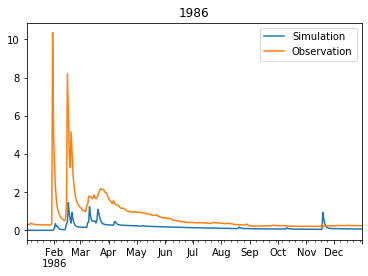

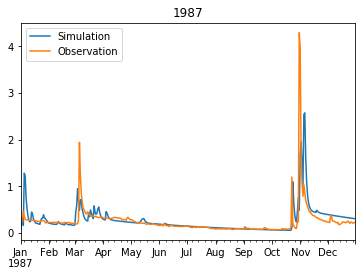

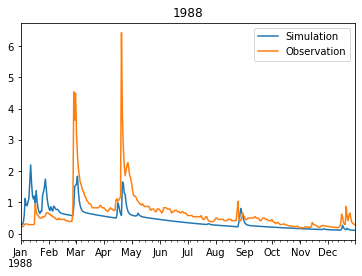

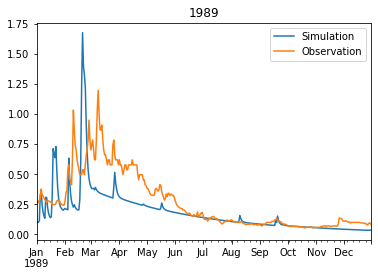

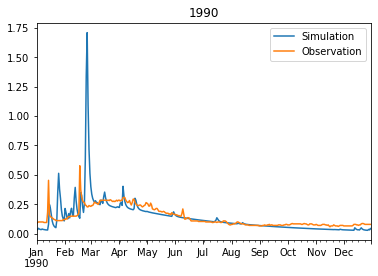

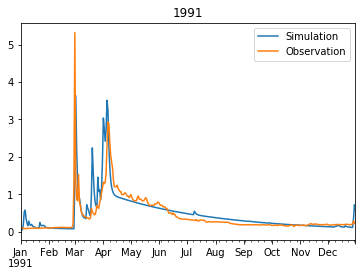

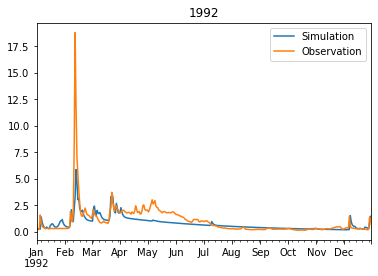

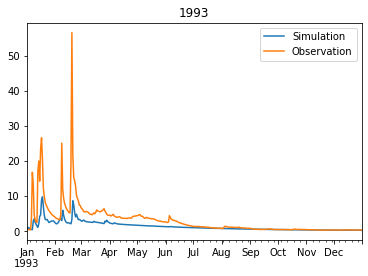

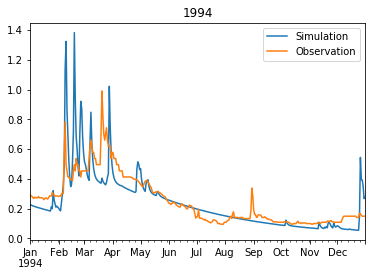

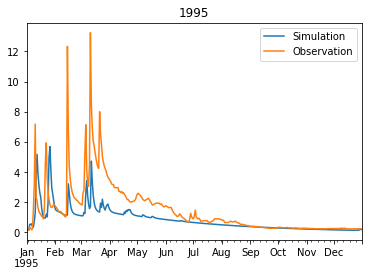

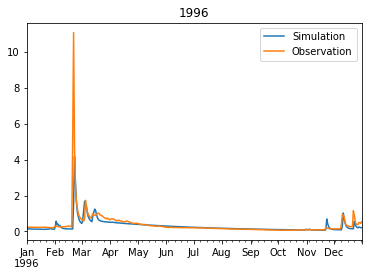

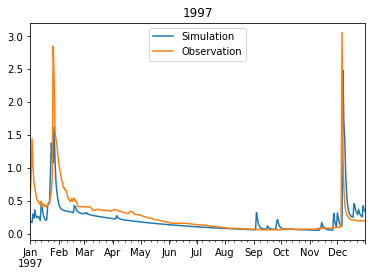

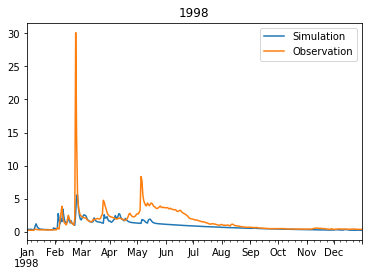

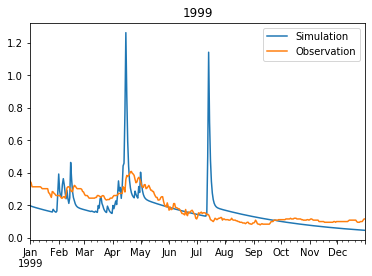

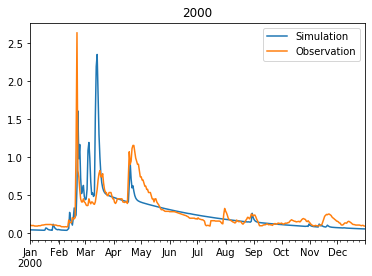

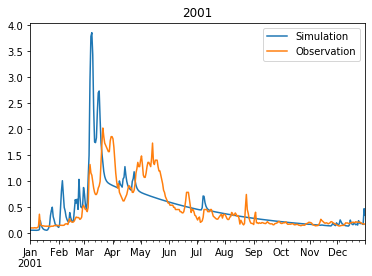

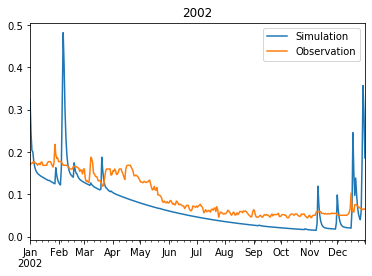

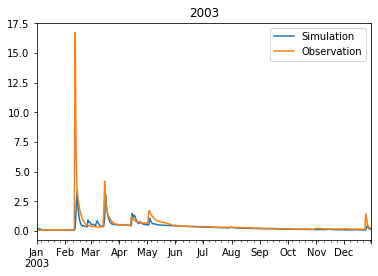

In [52]:
plt.figure(figsize=[16,8])
diff = combined_discharge.streamflow- combined_discharge.simulation
for i in range(1986, 2004):
    plt.figure()
    combined_discharge.simulation.loc[combined_discharge.index.year == i].plot(label='Simulation')
    combined_discharge.streamflow.loc[combined_discharge.index.year == i].plot(label='Observation')
    plt.title(i)
    plt.legend()
    
# diff.plot(color='black', label='difference', alpha=0.5)




# plt.legend();
# plt.figure(figsize=[16,8])


In [ ]:
model.finalize()

[0.7599267848259975,
 0.2813994807338532,
 1.0771969104804655,
 4.009510870996008,
 0.6676913212599985,
 1.3357459933440057,
 1.0473084360001281,
 0.6438389960903111,
 4.008755979821798,
 0.18316181441137466,
 0.6558363343211738,
 0.6020336764498682,
 0.11030228747160672,
 0.676352208858607]

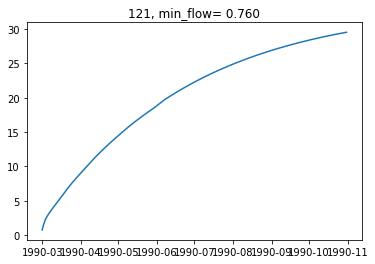

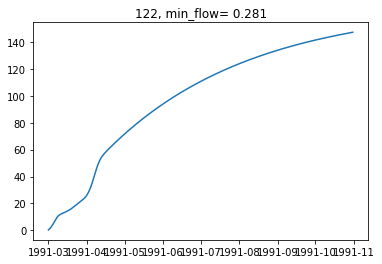

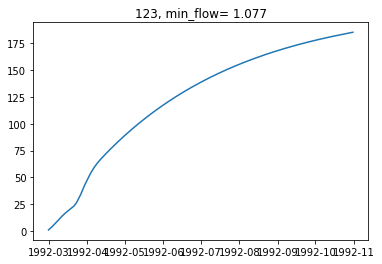

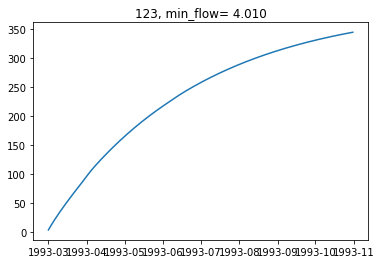

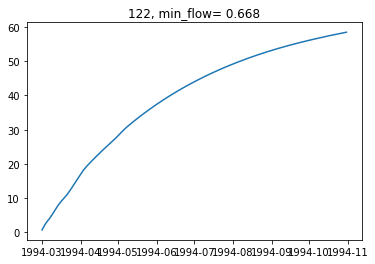

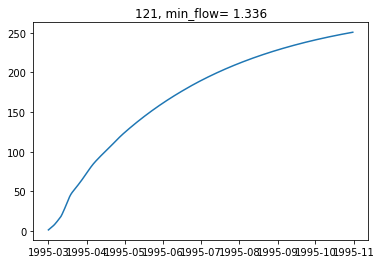

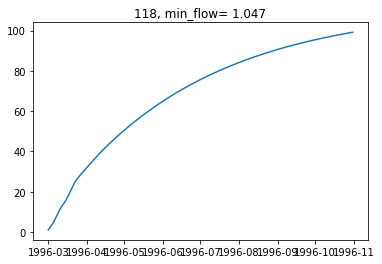

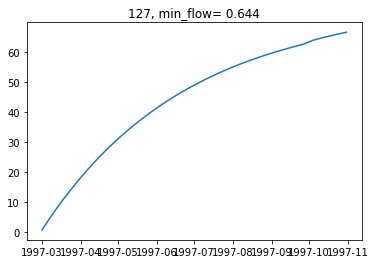

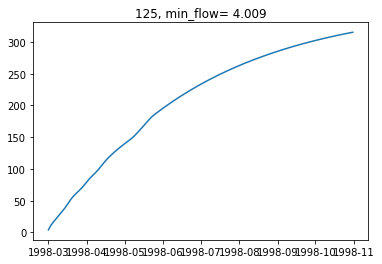

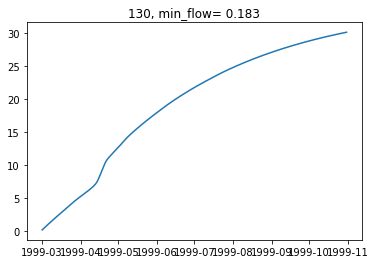

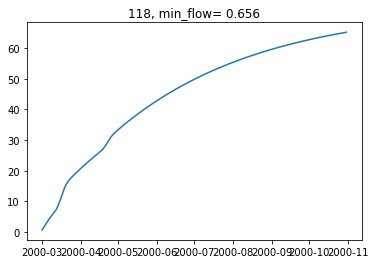

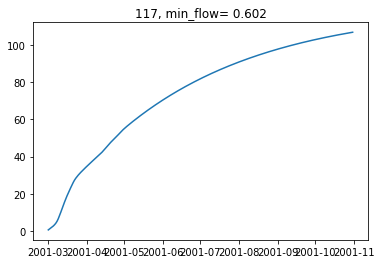

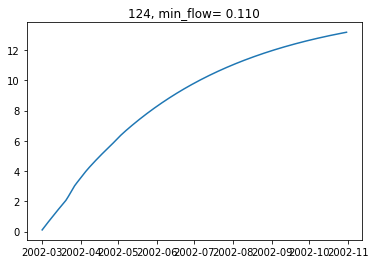

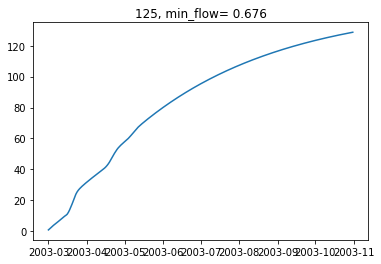

In [168]:
rolling = pd.DataFrame(combined_discharge.simulation.rolling(window=7).mean())
#     df['MA'] = df.rolling(window=5).mean()
doy = []
magn = []
for i in range(1990, 2004):
#     rolling_year = pd.DataFrame(rolling.loc[simulated_discharge_df.index.year == i])
    rolling_year = pd.DataFrame(rolling.loc[(combined_discharge.index >= datetime.datetime(i, 3, 1)) & (combined_discharge.index < datetime.datetime(i,11, 1))])
    rolling_year.reset_index(inplace=True)
    rolling_year.rename(columns={"index":"Date"}, inplace=True)
    rolling_year['cs'] = rolling_year.simulation.cumsum()
    plt.figure()
    plt.plot(rolling_year.Date, rolling_year.cs)
    plt.title(f'{rolling_year.loc[rolling_year.cs >= (0.75*rolling_year.cs.max())].index[0]}, min_flow= {rolling_year.cs.min():.3f}')
    doy.append(rolling_year.loc[rolling_year.cs >= (0.75*rolling_year.cs.max())].index[0])
    magn.append(rolling_year.cs.min())

#     magn.append(rolling_year.simulation.min())
#     doy.append(rolling_year.simulation.idxmin())
#     plt.figure()
#     plt.plot(rolling_year.Date, rolling_year.simulation)
#     plt.title(rolling_year.simulation.idxmin())   
magn

In [157]:

rolling.index = pd.to_datetime(rolling.index)
g = rolling.groupby(pd.TimeGrouper('y'))
g['cs'] = g.simulation.cumsum()
#     df['MA'] = df.rolling(window=5).mean()
# doy = []
# magn = []
# for i in range(1990, 2004):
# #     rolling_year = pd.DataFrame(rolling.loc[simulated_discharge_df.index.year == i])
#     rolling_year = pd.DataFrame(rolling.loc[(combined_discharge.index >= datetime.datetime(i, 3, 1)) & (combined_discharge.index < datetime.datetime(i,11, 1))])
#     rolling_year.reset_index(inplace=True)
#     rolling_year.rename(columns={"index":"Date"}, inplace=True)
#     if (rolling_year.simulation.min() <= 1):
#         doy.append(rolling_year.loc[rolling_year.simulation <= 1].index[0])
#     plt.figure()
#     plt.plot(rolling_year.Date, rolling_year.simulation)
#     plt.title(f'{rolling_year.loc[rolling_year.simulation <= 1].index[0]}, min_flow= {rolling_year.simulation.min():.3f}')
#     magn.append(rolling_year.simulation.min())

#     magn.append(rolling_year.simulation.min())
#     doy.append(rolling_year.simulation.idxmin())
#     plt.figure()
#     plt.plot(rolling_year.Date, rolling_year.simulation)
#     plt.title(rolling_year.simulation.idxmin())        

AttributeError: module 'pandas' has no attribute 'TimeGrouper'

In [156]:
rolling

,simulation
1986-01-02,NaN
1986-01-03,NaN
1986-01-04,NaN
1986-01-05,NaN
1986-01-06,NaN
...,...
2005-12-27,0.221132
2005-12-28,0.219159
2005-12-29,0.217208
2005-12-30,0.215283


In [131]:
np.mean(magn)

0.19974235473226468

In [72]:
# for i in range(1986, 1999):
#     plt.figure()
#     monthly_prec.loc[monthly_prec.index.year == i].plot()

In [16]:
# directory = 'output'
# bare_parametersets = pd.read_csv(os.path.join(directory, 'bare_paramsets.csv')).sort_values(by=['ED'])
# forest_parametersets = pd.read_csv(os.path.join(directory, 'forest_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])
# grass_parametersets = pd.read_csv(os.path.join(directory, 'grass_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])
# rip_parametersets = pd.read_csv(os.path.join(directory, 'rip_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])
# slow_parametersets = pd.read_csv(os.path.join(directory, 'slow_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])

In [73]:
# for i in np.arange(6, 16, 1):
#     plt.figure()
#     plt.xlabel='ED'
#     for j in range(len(forest_parametersets)):
#         plt.plot(forest_parametersets.iloc[j, 1], forest_parametersets.iloc[j, i], '.', color='blue')